In [1]:
import numpy as np
import pandas as pd
import glob
import scipy.misc
import tensorflow as tf
import scipy
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import cv2

In [4]:
import tqdm

In [2]:
df = pd.read_csv("apes_pivoted.csv")
df

,image_id,Background,Clothes,Earring,Eyes,Fur,Hat,Mouth
0,0,Orange,Striped Tee,Silver Hoop,X Eyes,Robot,NaN,Discomfort
1,1,Orange,Vietnam Jacket,NaN,Blue Beams,Robot,NaN,Grin
2,2,Aquamarine,NaN,NaN,3d,Robot,Sea Captain's Hat,Bored Cigarette
3,3,Purple,Bone Necklace,NaN,Bored,Cheetah,NaN,Tongue Out
4,4,Blue,Navy Striped Tee,NaN,Closed,Golden Brown,Party Hat 2,Phoneme L
...,...,...,...,...,...,...,...,...
9991,9995,Gray,Smoking Jacket,NaN,Closed,Pink,NaN,Bored
9992,9996,New Punk Blue,Guayabera,Silver Hoop,3d,Dark Brown,NaN,Dumbfounded
9993,9997,Purple,Sailor Shirt,NaN,Bored,Black,Halo,Grin Multicolored
9994,9998,Yellow,Bayc T Red,NaN,Heart,Brown,NaN,Bored Unshaven Cigarette


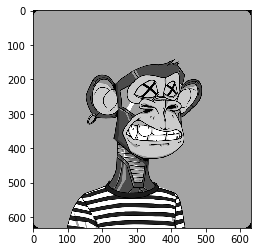

In [3]:
DIR = os.getcwd() + "\\images\\bored_apes"

for img in os.listdir(DIR): # iterating through images
    img_array = cv2.imread(os.path.join(DIR, img), cv2.IMREAD_GRAYSCALE)
    plt.imshow(img_array, cmap="gray")
    plt.show()

    break

In [5]:
df.columns

Index(['image_id', 'Background', 'Clothes', 'Earring', 'Eyes', 'Fur', 'Hat',
       'Mouth'],
      dtype='object')

In [12]:
from PIL import Image

all_data = []

for (i, row) in (df.iterrows()):
    try:
        img_id = row['image_id']

        background = row['Background']
        clothes = row['Clothes']
        earring = row['Earring']
        eyes = row['Eyes']
        fur = row['Fur']
        hat = row['Hat']
        mouth = row['Mouth']

        img_name = os.path.join(DIR, str(img_id) + '.jpg')
        if os.path.exists(img_name):
            image = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (150, 150))
            image = image.astype(np.float32)
            all_data.append([img_name, 
                            background,
                            clothes,
                            earring,
                            eyes,
                            fur,
                            hat,
                            mouth])
        else:
            print("Something went wrong: there is no file ", img_name)
    except:
        pass


In [13]:
len(all_data)

9962

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models


class MultiOutputModel(nn.Module):
    def __init__(self, n_background_classes, n_clothes_classes, n_earring_classes,
                    n_eyes_classes, n_fur_classes, n_hat_classes, n_mouth_classes):
        super().__init__()
        self.base_model = models.mobilenet_v2().features  # take the model without classifier
        last_channel = models.mobilenet_v2().last_channel  # size of the layer before classifier

        # the input for the classifier should be two-dimensional, but we will have
        # [batch_size, channels, width, height]
        # so, let's do the spatial averaging: reduce width and height to 1
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # create separate classifiers for our outputs
        self.color = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=last_channel, out_features=n_color_classes)
        )
        self.gender = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=last_channel, out_features=n_gender_classes)
        )
        self.article = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=last_channel, out_features=n_article_classes)
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.pool(x)

        # reshape from [batch, channels, 1, 1] to [batch, channels] to put it into classifier
        x = torch.flatten(x, 1)

        return {
            'color': self.color(x),
            'gender': self.gender(x),
            'article': self.article(x)
        }

    def get_loss(self, net_output, ground_truth):
        color_loss = F.cross_entropy(net_output['color'], ground_truth['color_labels'])
        gender_loss = F.cross_entropy(net_output['gender'], ground_truth['gender_labels'])
        article_loss = F.cross_entropy(net_output['article'], ground_truth['article_labels'])
        loss = color_loss + gender_loss + article_loss
        return loss, {'color': color_loss, 'gender': gender_loss, 'article': article_loss}

In [ ]:
x = np.asarray(all_dta)

In [ ]:
class FashionDataset(Dataset):
    def __init__(...):
    ...
    # initialize the arrays to store the ground truth labels and paths to the images
    self.data = []
    self.color_labels = []
    self.gender_labels = []
    self.article_labels = []
 
    # read the annotations from the CSV file
    with open(annotation_path) as f:
        reader = csv.DictReader(f)
        for row in reader:
            self.data.append(row['image_path'])
            self.color_labels.append(self.attr.color_name_to_id[row['baseColour']])
            self.gender_labels.append(self.attr.gender_name_to_id[row['gender']])
            self.article_labels.append(self.attr.article_name_to_id[row['articleType']])